In [2]:
import numpy as np
from scipy import special
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 14

# Calculation of vertical displacement due to loading

## Step1: Comparision with Argus et al. (2017)

$$ d = Gm $$

- d: data (displacement; $n_d\times1$)
- m: model (mass; $n_m\times1$)

In [3]:
def calc_deformation_disk(M, lamda, mu, alpha, r):
    ''' 
    Calculates the deformation for a disk of mass M and radius alpha, on top of a substrate with Lame parameter lambda and shear modulus mu.
    M: mass of the disk, kg
    lamda: Lame parameter of substrate
    mu: shear modulus of substrate
    alpha: disk radius, in metres
    r: array of distances from centre of disk at which to calculate solution. In metres. eg r = np.linspace(0,50*10**3,num=1000) to go to 50km distance.
    
    '''
    sigma=lamda+2*mu
    nabla=lamda + mu
    
    defm=np.zeros_like(r)
    
    r_disk = r[r<=alpha]
    r_postdisk = r[r>=alpha]
    
    defm[r<=alpha]=-M * g* (sigma/(np.pi**2 * mu * nabla * alpha) * special.ellipe((r_disk/alpha)**2) )  
    defm[r>=alpha]= -M *g* (sigma* r_postdisk / (np.pi**2 * mu * nabla * alpha**2)) * (special.ellipe((alpha/r_postdisk)**2) - (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)) 
    
    return defm

In [4]:
# These are the displacements which I picked by hand from Argus 2017
argus_traced_14_disp = -1*np.array([2.6, 2.3, 1.4, 0.7, 0.3, 0.15]) 
# And these are the corresponding distances in kilometres
argus_traced_14_distance = [0,9,16,20,36,50]

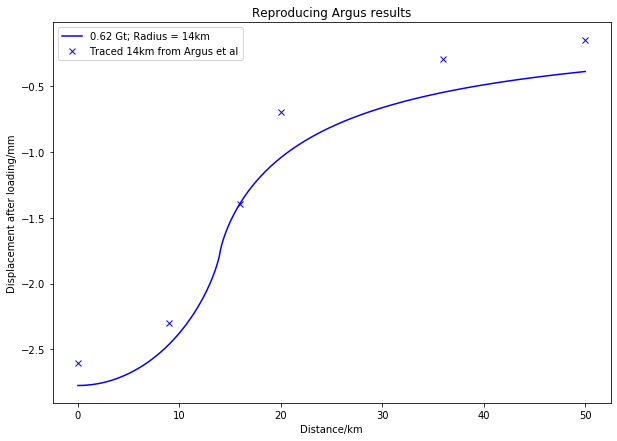

In [5]:
g = 9.81 # Seogi: gravity acceleration?
lamda = 25*10**9 # Lame parameter of granite
mu = 40*10**9 # Shear modulus of granite
M = np.pi * (14*10**3)**2 * 1 * 1000
alpha = 14*10**3
r_argus = np.linspace(0,50*10**3,num=1000)

delta_d = calc_deformation_disk(M,lamda,mu,alpha,r_argus)
#delta_d_2d = calc_deformation_2Ddisk(M,lamda,mu,alpha,r_argus)

fig,ax = plt.subplots(1,1,figsize=(10,7))
plt.plot(
    r_argus/1000,delta_d*1000,color='blue',
    label="0.62 Gt; Radius = 14km"
) 
plt.plot(
    argus_traced_14_distance,argus_traced_14_disp,'x',
    color='blue',
    label="Traced 14km from Argus et al"
)

plt.xlabel('Distance/km')
plt.ylabel('Displacement after loading/mm')

plt.title("Reproducing Argus results")


plt.legend()
plt.show()

## Step2: Create SimPEG `Problem` class

In [86]:
from SimPEG.Problem import BaseProblem
from SimPEG.Survey import BaseSurvey
from SimPEG import Props, Maps

class SWEProblem(BaseProblem):
    
    mass, massMap, massDeriv = Props.Invertible(
        "Mass (giga tonne)"
    )

    mu = Props.PhysicalProperty(
        "Shear modulus (??)",
        default=40.*10**9
    )
    
    alpha = Props.PhysicalProperty(
        "Disk radius (m)",
        default=14.*10**3
    )
    
    lamda = Props.PhysicalProperty(
        "Lame parameter (??)",
        default=25.*10**9
    )    
    
    _G = None
    cylinder_locations = None
    
    def __init__(self, mesh, **kwargs):
        BaseProblem.__init__(self, mesh, **kwargs)
        mapPair = Maps.IdentityMap  #: Type of mapping to pair with

    def fields(self, m):
        self.model = m
        return self.G.dot(self.massMap * m)

    def getJ(self, m, f=None):
        """
            Sensitivity matrix
        """

        if self.massMap is not None:
            dmudm = self.massMap.deriv(m)
            return self.G*dmudm
        else:
            return self.G

    @property
    def G(self):
        """
        Calculate G matrix to have a linear equation
        
        d = Gm
        
        """
        if getattr(self, '_G', None) is None:
            # assume a single disk at the moment
            # Todo: extend this for multiple cylinders?
            nM = self.mesh.nC
            self._G = np.zeros((self.survey.nD, nM))
            
            for ii in range(nM):
                sigma=self.lamda+2*mu
                nabla=self.lamda+mu
                r = np.sqrt(((self.survey.rx_locations-self.cylinder_locations[ii,:])**2).sum(axis=1))
                r_disk = r[r<=alpha]
                r_postdisk = r[r>=alpha]
                self._G[r<=alpha,ii] =-g* (
                    sigma/(np.pi**2 * mu * nabla * alpha) * 
                    special.ellipe((r_disk/alpha)**2) 
                )  # set the rows of G for receivers within the cylinder.
                self._G[r>=alpha,ii] = -g * (
                    (sigma* r_postdisk / (np.pi**2 * mu * nabla * alpha**2)) * 
                    (
                        special.ellipe((alpha/r_postdisk)**2) - 
                        (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)
                    ) # set the rows of G for recievers outside the cylinder.
                )
        return self._G * 1e12
    
    def Jvec(self, m, v, f=None):
        return self.G.dot(self.massMap.deriv(m) * v)

    def Jtvec(self, m, v, f=None):
        return self.massMap.deriv(m).T*self.G.T.dot(v)
    
class SWESurvey(BaseSurvey):
    
    rx_locations = None

    def __init__(self, **kwargs):
        BaseSurvey.__init__(self, **kwargs)
    
    def eval(self, f):
        return f

    @property
    def nD(self):
        return self.rx_locations.shape[0]

In [87]:
from SimPEG import Mesh

In [90]:
mesh = Mesh.TensorMesh([2,1,1])
cylinder_locations = np.array([[0, 0, 0],[50*10**3,0,0]])
x = np.linspace(0,50*10**3,num=5)
# x = np.array([0, 1000, 5000])
y = np.zeros_like(x)
z = np.zeros_like(x)

rx_locations = np.c_[x, y, z]
prob = SWEProblem(
    mesh, 
    massMap = Maps.IdentityMap(mesh),
    cylinder_locations=cylinder_locations,
    mu=np.array([mu, mu]),
    alpha=np.array([alpha, alpha]),    
)
survey = SWESurvey(rx_locations=rx_locations)
prob.pair(survey)
M = 1
model = np.array([M,M])
data = survey.makeSyntheticData(model, std=0.05)
# it is happening under the hood
# survey.dobs = pred

SimPEG.Survey assigned new std of 5.00%


In [91]:
prob.Jtvec(model, data)

array([4.68910039e-05, 4.84542653e-05])

In [92]:
data

array([-0.0049114 , -0.00424622, -0.00249464, -0.00445685, -0.00517796])

In [94]:
np.dot(prob.G.T, data)

array([4.68910039e-05, 4.84542653e-05])

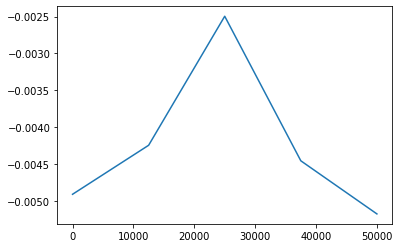

In [96]:
plt.plot(survey.rx_locations[:,0],data)
#plt.plot(delta_d, '.')

## Step2: Inversion

In [97]:
from SimPEG import Mesh
from SimPEG import Problem
from SimPEG import Survey
from SimPEG import DataMisfit
from SimPEG import Directives
from SimPEG import Optimization
from SimPEG import Regularization
from SimPEG import InvProblem
from SimPEG import Inversion


reg = Regularization.Tikhonov(mesh, alpha_s=1., alpha_x=1.)
dmis = DataMisfit.l2_DataMisfit(survey)
opt = Optimization.InexactGaussNewton(maxIter=60)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
target = Directives.TargetMisfit()
directives = [target]
invProb.beta = 0.
inv = Inversion.BaseInversion(invProb, directiveList=directives)
m0 = np.zeros(mesh.nC)
opt.tolG = 0.
opt.eps = 0.
opt.tolF = 0.
opt.tolX = 0.
mrec = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  9.99e+02  0.00e+00  9.99e+02    1.43e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 0.0000e+00
0 : |xc-x_last| = 1.3993e+00 <= tolX*(1+|x0|) = 0.0000e+00
0 : |proj(x-g)-x|    = 1.4259e+03 <= tolG          = 0.0000e+00
0 : |proj(x-g)-x|    = 1.4259e+03 <= 1e3*eps       = 0.0000e+00
0 : maxIter   =      60    <= iter          =      1
------------------------- DO

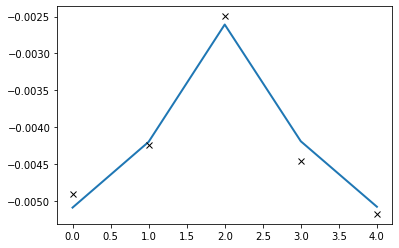

In [98]:
plt.plot(invProb.dpred, lw=2)
plt.plot(survey.dobs, 'kx')

In [102]:
H = np.dot(prob.G.T, prob.G)

In [103]:
g = prob.G.T.dot(data)

In [104]:
solution = np.linalg.solve(H, g)

In [105]:
solution

array([0.95904148, 1.0322809 ])

In [12]:
prob.cylinder_locations


array([[    0,     0,     0],
       [10000,     0,     0]])

In [13]:
survey.rx_locations


array([[    0.        ,     0.        ,     0.        ],
       [   50.05005005,     0.        ,     0.        ],
       [  100.1001001 ,     0.        ,     0.        ],
       ...,
       [49899.8998999 ,     0.        ,     0.        ],
       [49949.94994995,     0.        ,     0.        ],
       [50000.        ,     0.        ,     0.        ]])

In [14]:
data

array([-0.00514865, -0.00515319, -0.00515768, -0.00516211, -0.00516648,
       -0.0051708 , -0.00517507, -0.00517928, -0.00518343, -0.00518754,
       -0.00519159, -0.00519558, -0.00519953, -0.00520342, -0.00520726,
       -0.00521105, -0.00521479, -0.00521847, -0.00522211, -0.00522569,
       -0.00522923, -0.00523271, -0.00523615, -0.00523954, -0.00524287,
       -0.00524616, -0.0052494 , -0.00525259, -0.00525573, -0.00525883,
       -0.00526188, -0.00526488, -0.00526783, -0.00527073, -0.00527359,
       -0.0052764 , -0.00527917, -0.00528189, -0.00528456, -0.00528718,
       -0.00528976, -0.0052923 , -0.00529479, -0.00529723, -0.00529963,
       -0.00530198, -0.00530429, -0.00530656, -0.00530878, -0.00531095,
       -0.00531308, -0.00531517, -0.00531721, -0.00531921, -0.00532116,
       -0.00532307, -0.00532494, -0.00532676, -0.00532854, -0.00533028,
       -0.00533197, -0.00533362, -0.00533523, -0.0053368 , -0.00533832,
       -0.0053398 , -0.00534123, -0.00534263, -0.00534398, -0.00

In [15]:
survey.rx_locations[:,0]


array([    0.        ,    50.05005005,   100.1001001 ,   150.15015015,
         200.2002002 ,   250.25025025,   300.3003003 ,   350.35035035,
         400.4004004 ,   450.45045045,   500.5005005 ,   550.55055055,
         600.6006006 ,   650.65065065,   700.7007007 ,   750.75075075,
         800.8008008 ,   850.85085085,   900.9009009 ,   950.95095095,
        1001.001001  ,  1051.05105105,  1101.1011011 ,  1151.15115115,
        1201.2012012 ,  1251.25125125,  1301.3013013 ,  1351.35135135,
        1401.4014014 ,  1451.45145145,  1501.5015015 ,  1551.55155155,
        1601.6016016 ,  1651.65165165,  1701.7017017 ,  1751.75175175,
        1801.8018018 ,  1851.85185185,  1901.9019019 ,  1951.95195195,
        2002.002002  ,  2052.05205205,  2102.1021021 ,  2152.15215215,
        2202.2022022 ,  2252.25225225,  2302.3023023 ,  2352.35235235,
        2402.4024024 ,  2452.45245245,  2502.5025025 ,  2552.55255255,
        2602.6026026 ,  2652.65265265,  2702.7027027 ,  2752.75275275,
      